# Spectrum Sensing Delayed Feedback Reservoir (DFR)

## Import Packages

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Define Mackey-Glass Transfer Function

[Mackey-Glass equation on Scholarpedia](http://www.scholarpedia.org/article/Mackey-Glass_equation)

$$
y = \frac{2 \times x}{0.8 + 0.2(2.1 \times x)^{10}}
$$

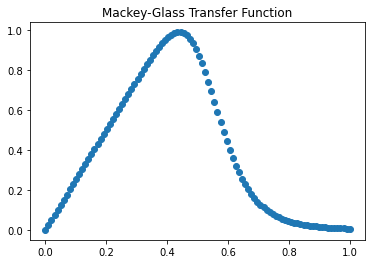

In [31]:
# mackey-glass function definition
def mg(x):
    a = 2
    b = 0.8
    c = 0.2
    d = 2.1
    p = 10

    return (a * x) / (b + c * np.power( (d * x), p) )

# graph mackey-glass function characteristics
x = np.linspace(0,1,100)
plt.title("Mackey-Glass Transfer Function")
plt.scatter(x,mg(x))
plt.show()

## Configure DFR Input Data Samples

In [32]:
num_samples = 6102

init_samples = 20
train_samples = 49 * init_samples
test_samples = num_samples - (init_samples + train_samples)

# max ADC output for signed/unsigned number
ADC_MAX_SIGNED = 2**11

# define sample offsets
TRAIN_INIT_BEGIN = 0
TRAIN_DATA_BEGIN = init_samples
TEST_DATA_BEGIN = init_samples + train_samples

In [33]:
SNR = "-10"
# SNR = "0"

ss_data = np.genfromtxt(f'./spectrum_data/spectrum_data_adc_{SNR}db.csv', delimiter=',')
i_data = ss_data[:,0]
q_data = ss_data[:,1]
i_data_norm = ( i_data / ADC_MAX_SIGNED )
q_data_norm = ( q_data / ADC_MAX_SIGNED )

x = np.sqrt(np.power(i_data_norm,2) + np.power(q_data_norm,2))
y = ss_data[:,2]

# index and save training and testing data
y_train = y[TRAIN_DATA_BEGIN:TEST_DATA_BEGIN]
y_test = y[TEST_DATA_BEGIN:]

## Configure DFR Properties

In [34]:
class DFR():
    def __init__(self,N,w_in,w_fb,reg):
        self.seed = 0
        self.rng = np.random.default_rng(self.seed)
        self.N = 50
        self.w_in = w_in
        self.w_fb = w_fb
        self.LAST_NODE = self.N - 1
        self.reg = 1e-8
        self.mask = self.rng.uniform(-0.5,0.5,self.N)

        self.W = None

        self.reservoir = np.zeros((self.N))
        self.reservoir_history = np.zeros((0,self.N))
        
        self.initializing = False
    
    def process(self,x):
        masked_sample = self.mask * x
        for j in range(self.N):
            self.reservoir[self.LAST_NODE - j] = mg(self.w_in * masked_sample[j] + self.w_fb * self.reservoir[self.LAST_NODE - j])
        if not self.initializing:
            self.reservoir_history = np.concatenate((self.reservoir_history,self.reservoir.reshape((1,self.N))))
        return self.reservoir

    def resetReservoir(self):
        self.reservoir = np.zeros((self.N))
        self.reservoir_history = np.zeros((0,self.N))
    
    def resetWeights(self):
        self.W = None
    
    def setInitMode(self,enable):
        self.initializing = enable
    
    def train(self,y_expect):
        self.W = np.dot(np.dot(y_expect,self.reservoir_history),np.linalg.inv((np.dot(self.reservoir_history.T,self.reservoir_history)) + self.reg * np.eye(self.N)))

    def readout(self):
        return self.reservoir_history.dot(self.W)


In [35]:
dfr = DFR(50,0.5,0.4,1e-8)

## Run DFR with Training Data

In [36]:
dfr.setInitMode(True)
for i in range(init_samples):
    dfr.process(x[TRAIN_INIT_BEGIN+i])
    
dfr.setInitMode(False)
for i in range(train_samples):
    dfr.process(x[TRAIN_DATA_BEGIN+i])

## Calculate DFR Readout Weights using Ridge Regression

$$
W = \frac{\hat{y} \cdot X}{X^{T} \cdot X + \lambda I}
$$

In [37]:
dfr.train(y_train)

## Calculate Training Accuracy

In [38]:
# calculate DFR outputs
y_hat = dfr.readout()

# create matrix for binary spectrum predictions
y_hat_bin = y_hat.copy()
y_hat_bin[y_hat_bin >= 0.5] = 1
y_hat_bin[y_hat_bin < 0.5] = 0

# calculate accuracy
train_accuracy = (y_hat_bin == y_train).mean()
print(f"Ridge Regression Training Accuracy:\t{train_accuracy}")

auc = roc_auc_score(y_train, y_hat)
print('AUC: %.3f' % auc)

Ridge Regression Training Accuracy:	0.7122448979591837
AUC: 0.710


## Run DFR with Testing Data

In [39]:
dfr.resetReservoir()
for i in range(test_samples):
    dfr.process(x[TEST_DATA_BEGIN+i])

## Calculate Testing Accuracy

Ridge Regression Testing Accuracy:	0.5346922775382204
AUC: 0.662


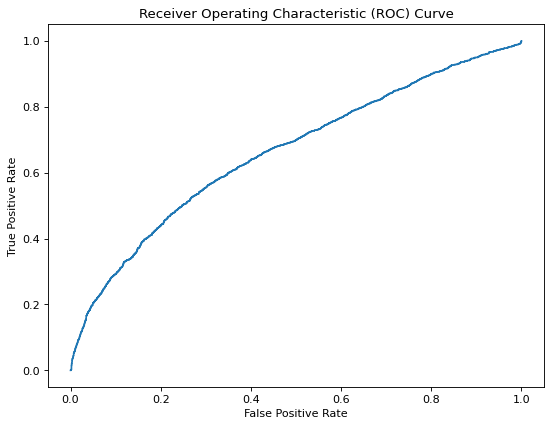

In [40]:
# calculate DFR outputs
y_hat = dfr.readout()

# create matrix for binary spectrum predictions
y_hat_bin = y_hat.copy()
y_hat_bin[y_hat_bin >= 0.5] = 1
y_hat_bin[y_hat_bin < 0.5] = 0

# calculate accuracy
test_accuracy = np.equal(y_hat_bin,y_test).mean()
print(f"Ridge Regression Testing Accuracy:\t{test_accuracy}")

# calculate AUC
auc = roc_auc_score(y_test, y_hat)
print('AUC: %.3f' % auc)

# show plot
plt.figure(figsize=(8, 6), dpi=80)
plt.clf()
fpr, tpr, _ = roc_curve(y_test, y_hat)
# plt.plot(fpr, tpr, marker='.')
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [43]:
with open("spectrum_sensing_params.csv","w") as dfrSpectrumParams:
    dfrSpectrumParams.write("N,W_IN,W_FB,AUC\n")
    for N in range(10,110,10):
        for w_in in np.arange(0.1,1,0.1):
            for w_fb in np.arange(0.1,1,0.1):

                dfr = DFR(N,w_in,w_fb,1e-8)

                dfr.setInitMode(True)
                for i in range(init_samples):
                    dfr.process(x[TRAIN_INIT_BEGIN+i])
                    
                dfr.setInitMode(False)
                for i in range(train_samples):
                    dfr.process(x[TRAIN_DATA_BEGIN+i])

                dfr.train(y_train)

                dfr.resetReservoir()
                for i in range(test_samples):
                    dfr.process(x[TEST_DATA_BEGIN+i])

                # calculate DFR outputs
                y_hat = dfr.readout()

                # create matrix for binary spectrum predictions
                y_hat_bin = y_hat.copy()
                y_hat_bin[y_hat_bin >= 0.5] = 1
                y_hat_bin[y_hat_bin < 0.5] = 0

                # calculate AUC
                auc = roc_auc_score(y_test, y_hat)
                print(f'N: %d\t W_IN: %f\t W_FB: %f\t AUC: %.3f' % (N,w_in, w_fb, auc))
                dfrSpectrumParams.write(f'%d,%f,%f,%.3f\n' % (N,w_in, w_fb, auc))

N: 10	 W_IN: 0.100000	 W_FB: 0.100000	 AUC: 0.797
N: 10	 W_IN: 0.100000	 W_FB: 0.200000	 AUC: 0.778
N: 10	 W_IN: 0.100000	 W_FB: 0.300000	 AUC: 0.742
N: 10	 W_IN: 0.100000	 W_FB: 0.400000	 AUC: 0.544
N: 10	 W_IN: 0.100000	 W_FB: 0.500000	 AUC: 0.541
N: 10	 W_IN: 0.100000	 W_FB: 0.600000	 AUC: 0.492
N: 10	 W_IN: 0.100000	 W_FB: 0.700000	 AUC: 0.512
N: 10	 W_IN: 0.100000	 W_FB: 0.800000	 AUC: 0.513
N: 10	 W_IN: 0.100000	 W_FB: 0.900000	 AUC: 0.512
N: 10	 W_IN: 0.200000	 W_FB: 0.100000	 AUC: 0.797
N: 10	 W_IN: 0.200000	 W_FB: 0.200000	 AUC: 0.778
N: 10	 W_IN: 0.200000	 W_FB: 0.300000	 AUC: 0.742
N: 10	 W_IN: 0.200000	 W_FB: 0.400000	 AUC: 0.667
N: 10	 W_IN: 0.200000	 W_FB: 0.500000	 AUC: 0.571
N: 10	 W_IN: 0.200000	 W_FB: 0.600000	 AUC: 0.513
N: 10	 W_IN: 0.200000	 W_FB: 0.700000	 AUC: 0.494
N: 10	 W_IN: 0.200000	 W_FB: 0.800000	 AUC: 0.516
N: 10	 W_IN: 0.200000	 W_FB: 0.900000	 AUC: 0.534
N: 10	 W_IN: 0.300000	 W_FB: 0.100000	 AUC: 0.797
N: 10	 W_IN: 0.300000	 W_FB: 0.200000	 AUC: 0.779


## Save DFR Properties for HLS Model

In [42]:
# mask
fh = open("./dfr_config/float_mask_data.txt","w")
for i in range(N):
    fh.write(str(mask[i]) + "\n")
fh.close()

# weights
fh = open("./dfr_config/float_weight_data.txt","w")
for i in range(N):
    fh.write(str(W[i]) + "\n")
fh.close()

NameError: name 'mask' is not defined

# Debug Outputs

In [ ]:
ss_data = np.genfromtxt(f'./spectrum_data/spectrum_data_adc_{SNR}db.csv', delimiter=',')
i_data = ss_data[:,0]
q_data = ss_data[:,1]

# max ADC output for signed/unsigned number
ADC_MAX_SIGNED = 2**11


i_data_norm = i_data / ADC_MAX_SIGNED
q_data_norm = q_data / ADC_MAX_SIGNED

x = np.sqrt(np.power(i_data_norm,2) + np.power(q_data_norm,2))
num_samples = len(x)

In [ ]:
seed = 0
rng = np.random.default_rng(seed)
mask = rng.uniform(-0.5,0.5,N)

# mask generation
masked_samples = np.empty((num_samples,N))
for i in range(num_samples):
    masked_samples[i] = mask * x[i]

In [ ]:
reservoir = np.zeros(N)
reservoir_history = np.zeros((num_samples,N))
for i in range(num_samples):
    for j in range(N):

        g_i = mg(gamma * masked_samples[i][j] + eta * reservoir[LAST_NODE])
        reservoir[1:N] = reservoir[0:LAST_NODE]
        reservoir[0] = g_i

    reservoir_history[i] = reservoir

In [ ]:
# calculate DFR outputs
y = reservoir_history.dot(W)